[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      8422
           1       0.98      0.95      0.96     11233

    accuracy                           0.96     19655
   macro avg       0.96      0.96      0.96     19655
weighted avg       0.96      0.96      0.96     19655

Epoch 1: Accuracy = 0.9604
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8422
           1       0.97      0.96      0.96     11233

    accuracy                           0.96     19655
   macro avg       0.96      0.96      0.96     19655
weighted avg       0.96      0.96      0.96     19655

Epoch 2: Accuracy = 0.9591
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8422
           1       0.98      0.96      0.97     11233

    accuracy                           0.96     19655
   macro avg       0.96      0.97      0.96     19655
weighted avg       0

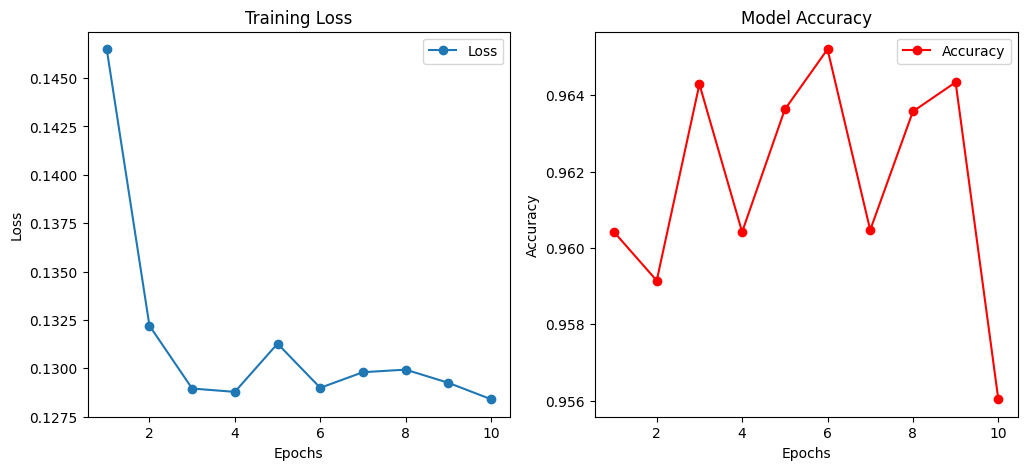

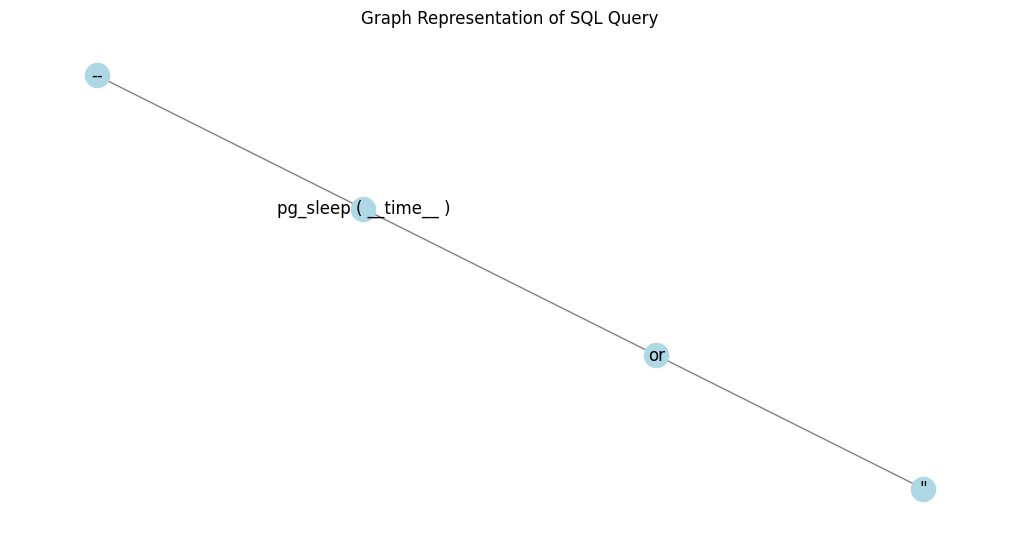

In [3]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
import networkx as nx
import nltk
import sqlparse
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Download NLTK tokenizer
nltk.download("punkt_tab")

def load_dataset(filepath):
    df = pd.read_csv(filepath)
    return df["Query"].tolist(), df["Label"].tolist()

def tokenize_sql(query):
    parsed_query = sqlparse.parse(query)
    tokens = [token.value.lower() for statement in parsed_query for token in statement.tokens if token.value.strip()]
    return tokens

def train_word2vec(queries):
    tokenized_queries = [tokenize_sql(query) for query in queries]
    model = Word2Vec(sentences=tokenized_queries, vector_size=50, window=5, min_count=1, workers=4)
    return model

def build_graph(query, word2vec_model, label):
    tokens = tokenize_sql(query)
    graph = nx.Graph()
    for i, token in enumerate(tokens):
        if token in word2vec_model.wv:
            graph.add_node(i, x=torch.tensor(word2vec_model.wv[token], dtype=torch.float))
        else:
            graph.add_node(i, x=torch.zeros(50))
    for i in range(len(tokens) - 1):
        graph.add_edge(i, i + 1)
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    x = torch.stack([graph.nodes[i]["x"] for i in range(len(tokens))])
    return Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return x

queries, labels = load_dataset("/kaggle/input/cyber-cia/trainingdata.csv")
word2vec_model = train_word2vec(queries)
graph_data = [build_graph(q, word2vec_model, l) for q, l in zip(queries, labels)]
train_graphs, test_graphs = train_test_split(graph_data, test_size=0.2, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(in_channels=50, hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_history = []
accuracy_history = []

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_history.append(total_loss / len(train_loader))

def evaluate():
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(data.y.cpu().numpy())
    acc = accuracy_score(true_labels, predictions)
    accuracy_history.append(acc)
    print(classification_report(true_labels, predictions))
    return acc

for epoch in range(10):
    train()
    acc = evaluate()
    print(f"Epoch {epoch+1}: Accuracy = {acc:.4f}")

# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), loss_history, marker='o', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), accuracy_history, marker='o', color='r', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Visualize sample query as graph
def visualize_graph(query):
    graph = nx.Graph()
    tokens = tokenize_sql(query)
    for i, token in enumerate(tokens):
        graph.add_node(i, label=token)
    for i in range(len(tokens) - 1):
        graph.add_edge(i, i + 1)
    plt.figure(figsize=(10, 5))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, labels=nx.get_node_attributes(graph, 'label'), node_color='lightblue', edge_color='gray')
    plt.title("Graph Representation of SQL Query")
    plt.show()

# Show sample query visualization
visualize_graph(queries[0])

In [2]:
!pip uninstall torch-geometric -y
!pip install torch-geometric --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:00a 0:00:01
